In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')


In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Загрузка данных
train_df = pd.read_csv('train_oil.csv')
test_df = pd.read_csv('oil_test.csv')

In [ ]:
print("Размер тренировочных данных:", train_df.shape)
print("Размер тестовых данных:", test_df.shape)

# Проверим точное название целевой колонки
target_column = None
for col in train_df.columns:
    if 'onshore' in col.lower() or 'offshore' in col.lower():
        target_column = col
        break

if target_column is None:
    target_column = train_df.columns[-1]

print(f"Целевая колонка: '{target_column}'")

Размер тренировочных данных: (309, 20)
Размер тестовых данных: (133, 19)
Целевая колонка: 'Onshore/Offshore'


In [ ]:


# Анализ целевой переменной
print("\nРаспределение целевой переменной:")
print(train_df[target_column].value_counts())

# Преобразуем целевую переменную
def prepare_target(df, target_col):
    df = df.copy()

    # Преобразуем строковые значения в числовые
    if df[target_col].dtype == 'object':
        mapping = {'OFFSHORE': 0, 'ONSHORE': 1, 'ONSHORE-OFFSHORE': 2}
        df[target_col] = df[target_col].map(mapping)
        # Заполняем пропуски наиболее частым классом
        df[target_col] = df[target_col].fillna(df[target_col].mode()[0] if not df[target_col].mode().empty else 0)


    # Удаляем смешанные месторождения (ONSHORE-OFFSHORE - 2)
    df = df[df[target_col] != 2]

    # Преобразуем в бинарную
    df['target'] = df[target_col].apply(lambda x: 1 if x == 1 else 0)
    return df


Распределение целевой переменной:
Onshore/Offshore
ONSHORE             218
OFFSHORE             86
ONSHORE-OFFSHORE      5
Name: count, dtype: int64


In [ ]:
def handle_outliers(df):
    df = df.copy()

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Заменяем выбросы граничными значениями
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

In [ ]:
train_df_clean = prepare_target(train_df, target_column)
print(f"\nПосле очистки: {train_df_clean.shape[0]} строк")
print("Распределение классов:")
print(train_df_clean['target'].value_counts())
print(f"Дисбаланс классов: {train_df_clean['target'].value_counts(normalize=True)}")


После очистки: 304 строк
Распределение классов:
target
1    218
0     86
Name: count, dtype: int64
Дисбаланс классов: target
1    0.717105
0    0.282895
Name: proportion, dtype: float64


In [ ]:
# Анализ дисбаланса
class_ratio = train_df_clean['target'].value_counts()[0] / train_df_clean['target'].value_counts()[1]
print(f"Соотношение классов (OFFSHORE/ONSHORE): {class_ratio:.2f}")

Соотношение классов (OFFSHORE/ONSHORE): 0.39


In [ ]:
# Функция для предобработки признаков
def preprocess_features_simple(df, target_col):
    df_processed = df.copy()

    # Удаляем неинформативные колонки
    columns_to_drop = ['Field name', 'Reservoir unit', 'Country', 'Region',
                      'Basin name', 'Operator company', target_col, 'target']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
    df_processed = df_processed.drop(columns=existing_columns_to_drop)

    print(f"Колонки для обучения: {df_processed.columns.tolist()}")

    # Преобразуем все объектные колонки в числовые
    for col in df_processed.select_dtypes(include=['object']).columns:
        if col in df_processed.columns:
            # Используем простое кодирование
            df_processed[col] = df_processed[col].astype('category').cat.codes
            # Заменяем -1 на 0 (для пропущенных значений)
            df_processed[col] = df_processed[col].replace(-1, 0)

    # Заполняем пропущенные значения
    for col in df_processed.columns:
        if df_processed[col].isnull().any():
            if df_processed[col].dtype in ['float64', 'int64']:
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
            else:
                df_processed[col] = df_processed[col].fillna(0)

    return df_processed

In [ ]:


# Предобработка данных

X_train = preprocess_features_simple(train_df_clean, target_column)
y_train = train_df_clean['target']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Проверяем, что нет пропущенных значений
print(f"Пропущенные значения в X_train: {X_train.isnull().sum().sum()}")

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)


=== ПРЕДОБРАБОТКА ДАННЫХ ===
Колонки для обучения: ['Tectonic regime', 'Latitude', 'Longitude', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Depth', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability']
X_train shape: (304, 13), y_train shape: (304,)
Пропущенные значения в X_train: 0


In [ ]:
# Вариант 1: Логистическая регрессия с балансировкой классов
model1 = LogisticRegression(
    random_state=54,
    max_iter=1000,
    C=0.9,
    solver='liblinear',
    class_weight='balanced'  # Автоматическая балансировка классов
)

# Вариант 2: Логистическая регрессия с ручной балансировкой
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

model2 = LogisticRegression(
    random_state=54,
    max_iter=1000,
    C=0.8,
    solver='liblinear',
    class_weight=class_weight_dict
)

# Вариант 3: Логистическая регрессия без балансировки (для сравнения)
model3 = LogisticRegression(
    random_state=54,
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)

models = {
    'Balanced (auto)': model1,
    'Balanced (manual)': model2,
    'No balancing': model3
}


In [ ]:
results = {}
for name, model in models.items():
    print(f"\n--- Модель: {name} ---")

    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"F1-score (CV): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Обучение на всех данных
    model.fit(X_train_scaled, y_train)

    # Предсказания
    y_pred = model.predict(X_train_scaled)
    y_proba = model.predict_proba(X_train_scaled)[:, 1]

    # Метрики
    f1 = f1_score(y_train, y_pred)
    accuracy = (y_pred == y_train).mean()

    print(f"F1-score (train): {f1:.4f}")
    print(f"Accuracy (train): {accuracy:.4f}")
    print(f"Распределение предсказаний: {pd.Series(y_pred).value_counts().to_dict()}")

    results[name] = {
        'model': model,
        'f1': f1,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_proba
    }



--- Модель: Balanced (auto) ---
F1-score (CV): 0.8337 (+/- 0.0976)
F1-score (train): 0.8642
Accuracy (train): 0.8191
Распределение предсказаний: {1: 187, 0: 117}

--- Модель: Balanced (manual) ---
F1-score (CV): 0.8356 (+/- 0.0919)
F1-score (train): 0.8642
Accuracy (train): 0.8191
Распределение предсказаний: {1: 187, 0: 117}

--- Модель: No balancing ---
F1-score (CV): 0.8363 (+/- 0.0376)
F1-score (train): 0.8597
Accuracy (train): 0.7961
Распределение предсказаний: {1: 224, 0: 80}


In [ ]:
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']
print(f"\n Лучшая модель: {best_model_name}")


 Лучшая модель: Balanced (auto)



=== ВИЗУАЛИЗАЦИИ ===


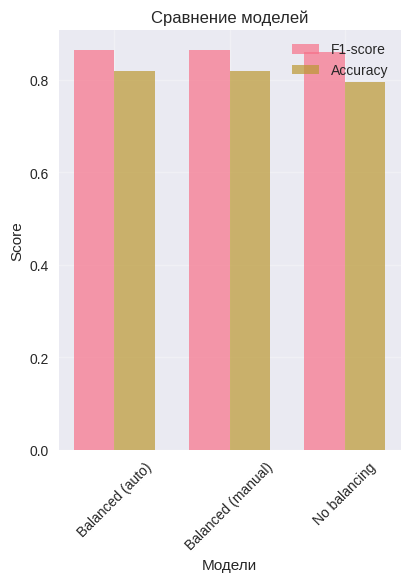

In [ ]:

plt.figure(figsize=(15, 12))

# 1. Сравнение моделей
plt.subplot(2, 3, 1)
model_names = list(results.keys())
f1_scores = [results[name]['f1'] for name in model_names]
acc_scores = [results[name]['accuracy'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, f1_scores, width, label='F1-score', alpha=0.7)
plt.bar(x + width/2, acc_scores, width, label='Accuracy', alpha=0.7)

plt.xlabel('Модели')
plt.ylabel('Score')
plt.title('Сравнение моделей')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

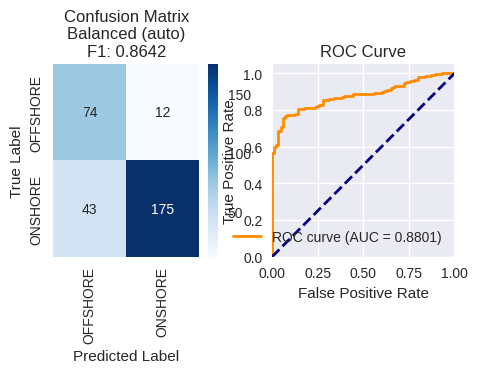

In [ ]:
plt.subplot(2, 3, 2)
y_best_pred = results[best_model_name]['predictions']
cm = confusion_matrix(y_train, y_best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['OFFSHORE', 'ONSHORE'],
            yticklabels=['OFFSHORE', 'ONSHORE'])
plt.title(f'Confusion Matrix\n{best_model_name}\nF1: {results[best_model_name]["f1"]:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 3. ROC-кривая
plt.subplot(2, 3, 3)
y_best_proba = results[best_model_name]['probabilities']
fpr, tpr, thresholds = roc_curve(y_train, y_best_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

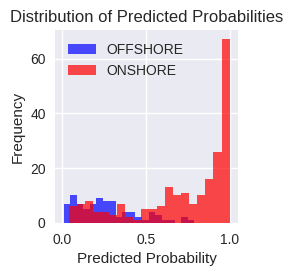

In [ ]:
plt.subplot(2, 3, 4)
plt.hist(y_best_proba[y_train == 0], alpha=0.7, label='OFFSHORE', bins=20, color='blue')
plt.hist(y_best_proba[y_train == 1], alpha=0.7, label='ONSHORE', bins=20, color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()


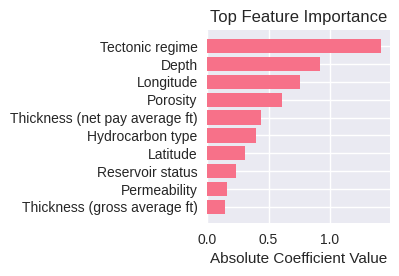

In [ ]:
# 5. Важность признаков
plt.subplot(2, 3, 5)
if hasattr(best_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': abs(best_model.coef_[0])
    }).sort_values('importance', ascending=True)

    n_features = min(10, len(feature_importance))
    plt.barh(feature_importance['feature'][-n_features:],
             feature_importance['importance'][-n_features:])
    plt.title('Top Feature Importance')
    plt.xlabel('Absolute Coefficient Value')
else:
    plt.text(0.5, 0.5, 'No coefficients', ha='center', va='center')
    plt.title('Feature Importance')

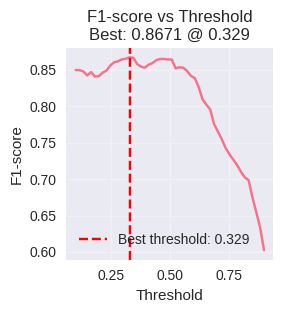


Лучший порог для классификации: 0.329


In [ ]:
# 6. Анализ порога
plt.subplot(2, 3, 6)
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores_thresh = []

for thresh in thresholds:
    y_pred_thresh = (y_best_proba > thresh).astype(int)
    f1_scores_thresh.append(f1_score(y_train, y_pred_thresh))

best_thresh = thresholds[np.argmax(f1_scores_thresh)]
best_f1 = max(f1_scores_thresh)

plt.plot(thresholds, f1_scores_thresh)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best threshold: {best_thresh:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title(f'F1-score vs Threshold\nBest: {best_f1:.4f} @ {best_thresh:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nЛучший порог для классификации: {best_thresh:.3f}")

In [ ]:
# Обрабатываем тестовые данные
X_test = preprocess_features_simple(test_df, target_column)

# Выравниваем колонки
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[X_train.columns]

# Масштабируем
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Предсказания с лучшей моделью
test_probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

# Используем оптимальный порог
test_predictions_optimized = (test_probabilities > best_thresh).astype(int)

# Также получаем предсказания без оптимизации порога
test_predictions_default = best_model.predict(X_test_scaled)

print(f"Распределение предсказаний (по умолчанию):")
print(pd.Series(test_predictions_default).value_counts().sort_index())

print(f"Распределение предсказаний (оптимизированный порог {best_thresh:.3f}):")
print(pd.Series(test_predictions_optimized).value_counts().sort_index())

# Создаем оба варианта submission
submission_default = pd.DataFrame({
    'index': range(len(test_predictions_default)),
    'Onshore/Offshore': test_predictions_default
})

submission_optimized = pd.DataFrame({
    'index': range(len(test_predictions_optimized)),
    'Onshore/Offshore': test_predictions_optimized
})

# Сохраняем оба варианта
submission_default.to_csv('submission_default.csv', index=False)
submission_optimized.to_csv('submission.csv', index=False)

Колонки для обучения: ['Tectonic regime', 'Latitude', 'Longitude', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Depth', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability']
Распределение предсказаний (по умолчанию):
0    48
1    85
Name: count, dtype: int64
Распределение предсказаний (оптимизированный порог 0.329):
0     31
1    102
Name: count, dtype: int64


In [ ]:
print(f"   - submission_default.csv (порог 0.5)")
print(f"   - submission.csv (оптимизированный порог {best_thresh:.3f})")

print(f"\nПервые 10 строк оптимизированного submission:")
print(submission_optimized.head(10))

# Анализ качества предсказаний
print(f"\n=== АНАЛИЗ КАЧЕСТВА ===")
print(f"Лучшая модель: {best_model_name}")
print(f"F1-score на тренировочных данных: {results[best_model_name]['f1']:.4f}")
print(f"Оптимальный порог классификации: {best_thresh:.3f}")
print(f"Используемые признаки ({X_train.shape[1]}): {list(X_train.columns)}")

# Проверяем, что в submission есть оба класса
final_predictions = submission_optimized['Onshore/Offshore'].value_counts()
print(f"\nФинальное распределение в submission:")
for class_id, count in final_predictions.sort_index().items():
    class_name = 'ONSHORE' if class_id == 1 else 'OFFSHORE'
    percentage = count / len(submission_optimized) * 100
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

if len(final_predictions) == 1:
    print(" Внимание: В submission только один класс!")
    print("Попробуем использовать более агрессивный порог...")

    # Пробуем порог, который даст больше предсказаний класса 1
    alternative_threshold = 0.3
    test_predictions_alt = (test_probabilities > alternative_threshold).astype(int)

    submission_alt = pd.DataFrame({
        'index': range(len(test_predictions_alt)),
        'Onshore/Offshore': test_predictions_alt
    })

    submission_alt.to_csv('submission_alternative.csv', index=False)
    print(f"Создан альтернативный submission с порогом {alternative_threshold}")

   - submission_default.csv (порог 0.5)
   - submission.csv (оптимизированный порог 0.329)

Первые 10 строк оптимизированного submission:
   index  Onshore/Offshore
0      0                 1
1      1                 0
2      2                 1
3      3                 0
4      4                 1
5      5                 0
6      6                 1
7      7                 0
8      8                 1
9      9                 1

=== АНАЛИЗ КАЧЕСТВА ===
Лучшая модель: Balanced (auto)
F1-score на тренировочных данных: 0.8642
Оптимальный порог классификации: 0.329
Используемые признаки (13): ['Tectonic regime', 'Latitude', 'Longitude', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 'Depth', 'Reservoir period', 'Lithology', 'Thickness (gross average ft)', 'Thickness (net pay average ft)', 'Porosity', 'Permeability']

Финальное распределение в submission:
  OFFSHORE: 31 samples (23.3%)
  ONSHORE: 102 samples (76.7%)
